In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

def draw_plot(rang, *funcs, xlog=False, ylog=False, legend=None):
    xs = []
    ys = []
    for _ in funcs:
        ys.append([])
    
    for x in rang:
        xs.append(x)
        for i, f in enumerate(funcs):
            ys[i].append(f(x))
    
    for i, y in enumerate(ys):
        plt.plot(xs, y, label=None if legend is None else legend[i])
    
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    if legend:
        plt.legend()
    
    plt.show()
    
def list_func(l):
    return lambda n: l[n]

### Задание 11

Выпишем сеточную задачу:

Имеем следующее: 

$$ -\psi''(r) + l(l + 1)r^{-2}\psi(r) - 2r^{-1}\psi(r) = 2E_{nl}\psi(r), \psi(0) = \psi(\infty) = 0$$

$$ \psi''(r) - l(l + 1)r^{-2}\psi(r) + 2r^{-1}\psi(r) = -2E_{nl}\psi(r), \psi(0) = \psi(\infty) = 0$$

Перегруппируем под задачу:

$$ \psi''(r) - (l(l + 1)r^{-2} - 2r^{-1})\psi(r) = -2E_{nl}\psi(r), \psi(0) = \psi(\infty) = 0$$

Получили, что $p_n(r) = l(l + 1)r^{-2} - 2r^{-1}, \rho_n(r) = 1, \lambda_n = E_{nl}$

При $l = 0$: $p_n(r) = - 2r^{-1}, \rho_n(r) = 1, \lambda_n = E_{n0} = -\frac{1}{2(n + 1)^2}$

Итого сеточная задача:

$$\frac{y_{n + 1} - 2y_n + y_{n - 1}}{h^2} + 2r_n^{-1}y_n = -2\lambda y_n$$


Видно, что $\lambda$ можно получить просто как решения $Ay = -2\lambda y$.
Построим для этого дела матрицу $A$:

In [113]:
def E(n, l):
    return np.float64(-1.) / np.float64(2. * np.float64(n + l + 1)**2)

def get_a(N, R):
    h = np.float64(R) / np.float64(N)
    a = np.zeros((N - 1, N - 1))
    for i in range(N - 1):
        a[i][i] = np.float64(-2. / h**2) + 2./ np.float64(h * (i + 1.))
        if i != 0:
            a[i][i - 1] = np.float64(1. / h**2)
        if i != N - 2:
            a[i][i + 1] = np.float64(1. / h**2)
    return a / 2
get_a(5, 10)

array([[ 0.25      ,  0.125     ,  0.        ,  0.        ],
       [ 0.125     ,  0.        ,  0.125     ,  0.        ],
       [ 0.        ,  0.125     , -0.08333333,  0.125     ],
       [ 0.        ,  0.        ,  0.125     , -0.125     ]])

Нам нужно получить точность в $10^{-5}$. Мы знаем, что точность имеет порядок $O(h^2)$, следовательно т.к. $h = \frac{R}{N}$, то для зафиксированного $R$ нужно вычислить $N$ как $O(\sqrt{\frac{R^2}{10^{-5}}})$. Построим на этом 5 собственных функций (понадеявшись, что внутри О скрывается коэффициент близкий к 1):

(0.499998013800775, 0.11280610691218786, -0.09142229445280795, -0.40515378565863047, -0.8263869858554598)
[-0.5, -0.125, -0.05555555555555555, -0.03125, -0.02]


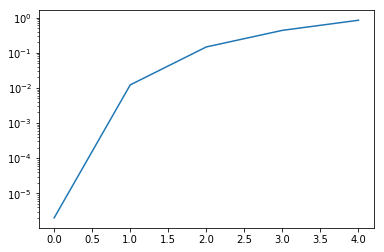

In [114]:
def get_N(R):
    return int(math.sqrt(R**2 * 10**5)) + 1

R = 10
N = get_N(R)

eval, evec =  np.linalg.eig(get_a(N, R))
ev_list = zip(eval, evec)
ev_list = sorted(ev_list, key=lambda tup:tup[0], reverse=True)
eval, evec = zip(*ev_list)

real_es = [E(i, 0) for i in range(5)]

print(eval[:5])
print(real_es)
draw_plot(range(5), list_func([abs(real_e + eig) for eig, real_e in zip(eval[:5], real_es)]), ylog=True)


Как видно, первое собственное число действительно оказалось близко к рельному с $\varepsilon = 10^{-5}$. То, что так не произошло с остальными векторами может быть комбинацией двух факторов: $R$ недостаточно ушло в бесконечность и внутри O на самом деле прячется чуть более сложная константа. (Но то, что числа переходят через 0 -- это точно первое).

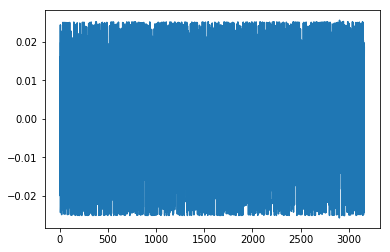

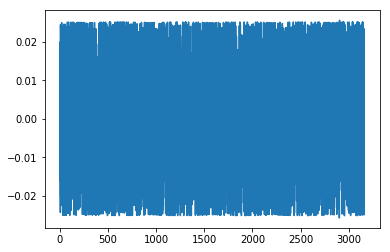

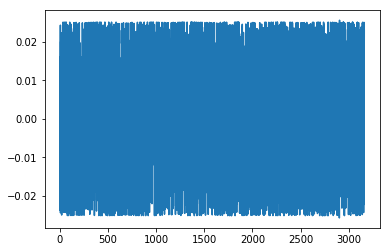

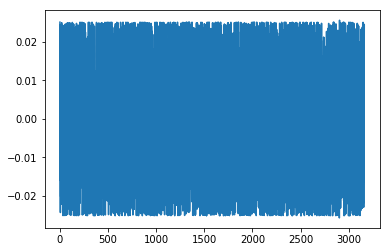

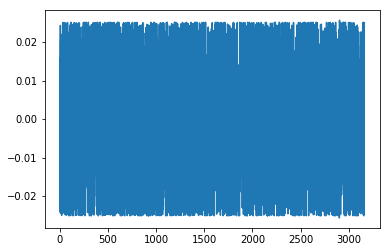

In [40]:
for vec in evec[:5]:
    draw_plot(range(0, N - 1), list_func(vec))

Тут ничего не видно. Увы.

Погворим о Нумерове. Он ускоряет выражения вида $y'' = -g(x)y + s(x)$. В нашем случае $s(x) = 0$, а  $g(x) = -p(x) + 2\lambda \rho(x)$.


Т.е. если бы обычно Нумеров предложил бы нам оценивать происходящее через уравнение:

$$\frac{12(y_{n + 1} - 2y_n + y_{n - 1})}{h^2} + y_{n + 1}g_{n + 1} + 10y_ng_n + y_{n - 1}g_{n - 1} + s_{n + 1} + 10 s_{n} + s_{n - 1} = 0$$

У нас $s$ нет вообще. А $g$ распалось на $-p(x) + 2\lambda \rho(x)$ = $2(\frac{1}{x} + \lambda)$. Итого получим 

$$\frac{12(y_{n + 1} - 2y_n + y_{n - 1})}{h^2} +2 y_{n + 1}(\frac{1}{x_{n + 1}} + \lambda) + 20y_n(\frac{1}{x_{n}} + \lambda) + 2 y_{n - 1}(\frac{1}{x_{n - 1}} + \lambda) = 0$$


$$\frac{6(y_{n + 1} - 2y_n + y_{n - 1})}{h^2} + \frac{y_{n + 1}}{x_{n + 1}} +\frac{10 y_n}{x_{n}} + \frac{y_{n - 1}}{x_{n - 1}} = -\lambda(y_{n + 1} + 10 y_{n} + y_{n - 1})$$

Вышла система $Ay + B\lambda y = 0 \Rightarrow -B^{-1}Ay = \lambda y$

Испольльзуем это.

In [149]:

def get_a_numerov(N, R):
    h = np.float64(R) / np.float64(N)
    a = np.zeros((N - 1, N - 1))
    b = np.zeros((N - 1, N - 1))
    
    for i in range(N - 1):
        a[i][i] = np.float64(-12. / h ** 2) + np.float64(10.) / np.float64(h * (i + 1.))
        b[i][i] = np.float(10.)
        if i != 0:
            a[i][i - 1] = np.float64(6. / h ** 2) + np.float64(1.) / np.float64(h * i)
            b[i][i - 1] = np.float64(1.)
        if i != N - 2:
            a[i][i + 1] = np.float64(6. / h ** 2) + np.float64(1.) / np.float64(h * (i + 2.))
            b[i][i + 1] = np.float64(1.)
    return np.matmul(np.linalg.inv(b), a)

get_a_numerov(5, 10)

array([[ 0.18163076,  0.1836924 , -0.01855479,  0.00185548],
       [ 0.1836924 , -0.08692403,  0.18554788, -0.01855479],
       [-0.01855479,  0.18554788, -0.17025736,  0.1836924 ],
       [ 0.00185548, -0.01855479,  0.1836924 , -0.19336924]])

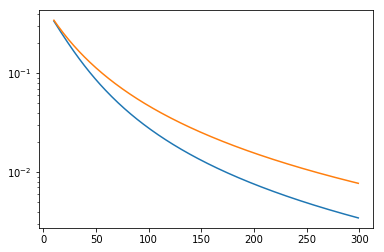

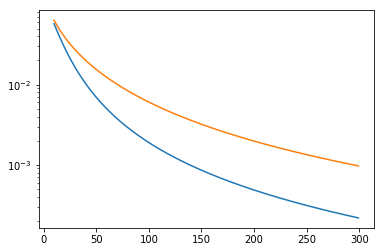

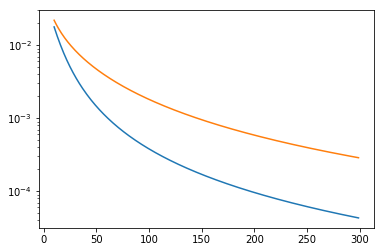

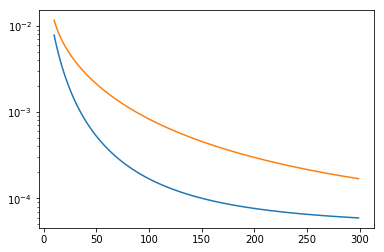

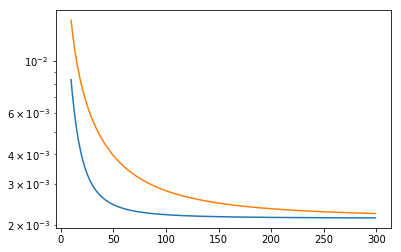

In [152]:
real_es = [E(i, 0) for i in range(5)]

R = 50

for i in range(5):
    draw_plot(range(10, 300), lambda N: abs(sorted(np.linalg.eig(get_a(N, R))[0], reverse=True)[i] + real_es[i]),
                              lambda N: abs(sorted(np.linalg.eig(get_a_numerov(N, R))[0], reverse=True)[i] + real_es[i]), ylog=True)




 Оба алгоритма сходятся хорошо. Почему-то явного профита Нумеров не принёс. Возможно, некая погрешность появляется в момент обращения матрицы B.